Counterfactual simulation model for government interventions
-------------------------------------------------------------------------

RNN-based approach to simulate the effect of timing and taking action on deaths-per-100k inhabitants.

In [1]:
import datetime
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.1.0'

In [3]:
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 100

#### Data sources

* The countermeasures data is made available as part of the John Hopkins [Containment Measures Database](http://epidemicforecasting.org/containment).
* The Oxford COVID-19 Government Response Tracker is made available as part of the [OxCGRT](https://www.bsg.ox.ac.uk/research/research-projects/oxford-covid-19-government-response-tracker) project.
* The country population data was gathered from the [Word Bank Databank](https://databank.worldbank.org/reports.aspx?source=2&series=SP.POP.TOTL&country=#), with latest data available for 2018.

In [4]:
johnshopkins_df = pd.read_csv("data/countermeasures_db_johnshopkins_2020_03_30.csv")
johnshopkins_df["Date"] = johnshopkins_df["Date"].apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d")).dt.date

In [5]:
oxford_grt_df = pd.read_csv("data/oxford_uni_response_tracker_08042020.csv")
oxford_grt_df["Date"] = oxford_grt_df["Date"].apply(lambda x: pd.to_datetime(str(x), format="%Y-%m-%d")).dt.date

In [6]:
grt_df = oxford_grt_df.drop_duplicates(subset=["CountryName", "StringencyIndex"], keep="first")

In [7]:
measures_df = pd.merge(johnshopkins_df, grt_df, how="outer", left_on=["Date", "Country"], 
                       right_on=["Date", "CountryName"])

In [8]:
population_df = pd.read_csv("data/wb_country_populations_2018.csv")[["Country Name", "2018 [YR2018]"]]
population_df.rename(columns={"2018 [YR2018]": "2018_Country_Population"}, inplace=True)

In [9]:
base_df = pd.merge(measures_df, population_df, how="outer", left_on="Country", right_on="Country Name").fillna(0)
base_df = base_df.loc[base_df["2018_Country_Population"] != ".."]
base_df = base_df.loc[base_df["Country"] != 0]

In [10]:
base_df.head()

,Unnamed: 0,Symptomatic isolation - targeted,Symptomatic isolation - blanket,Asymptomatic isolation - targeted,Asymptomatic isolation - blanket,Domestic travel restriction,International travel restriction,Testing,Contact tracing,Mask wearing,Hand washing,Gatherings banned,Healthcare specialisation,Public education and incentives,Assisting people to stay home,Public cleaning,Miscellaneous hygiene measures,Public interaction reduction,Nonessential business suspension,School closure,Activity cancellation,Resumption,Diagnostic criteria loosened,Diagnostic criteria tightened,Testing criteria,Date,Country,Confirmed Cases,Deaths,CountryName,CountryCode,S1_School closing,S1_IsGeneral,S1_Notes,S2_Workplace closing,S2_IsGeneral,S2_Notes,S3_Cancel public events,S3_IsGeneral,S3_Notes,S4_Close public transport,S4_IsGeneral,S4_Notes,S5_Public information campaigns,S5_IsGeneral,S5_Notes,S6_Restrictions on internal movement,S6_IsGeneral,S6_Notes,S7_International travel controls,S7_Notes,S8_Fiscal measures,S8_Notes,S9_Monetary measures,S9_Notes,S10_Emergency investment in health care,S10_Notes,S11_Investment in Vaccines,S11_Notes,S12_Testing framework,S12_Notes,S13_Contact tracing,S13_Notes,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,Unnamed: 39,Country Name,2018_Country_Population
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,Austria,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,Austria,8847037
1,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-24,Austria,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,Austria,8847037
2,172.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-25,Austria,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,Austria,8847037
3,258.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-26,Austria,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,Austria,8847037
4,344.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-27,Austria,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,Austria,8847037


In [11]:
print(base_df["Country"].unique())

['Austria' 'Germany' 'United Kingdom' 'Vietnam' 'South Korea' 'Singapore'
 'Israel' 'Japan' 'Sweden' 'San Marino' 'Slovenia' 'Canada' 'Taiwan'
 'Macau' 'Hong Kong' 'China' 'Thailand' 'Italy' 'Czechia' 'Australia'
 'Trinidad and Tobago' 'Qatar' 'New Zealand' 'Colombia' 'Romania' 'France'
 'Portugal' 'Spain' 'Belgium' 'Luxembourg' 'Albania' 'Andorra'
 'Azerbaijan' 'Belarus' 'Bosnia and Herzegovina' 'Bulgaria' 'Denmark'
 'Estonia' 'Cyprus' 'Croatia' 'Finland' 'Georgia' 'Hungary' 'Latvia'
 'Lithuania' 'Greece' 'Moldova' 'Malta' 'Monaco' 'Netherlands' 'Iceland'
 'Ireland' 'Kosovo' 'Kazakhstan' 'Poland' 'Turkey' 'Ukraine' 'Slovakia'
 'Serbia' 'Switzerland' 'Norway' 'Montenegro' 'Iran' 'Liechtenstein'
 'Russia' 'Mexico' 'Egypt' 'Malaysia' 'Nepal' 'Afghanistan' 'Iraq'
 'Philippines' 'Kuwait' 'South Africa' 'Armenia' 'Pakistan' 'Brazil'
 'Costa Rica' 'Panama' 'India' 'Bahrain' 'United Arab Emirates'
 'Kyrgyzstan' 'Indonesia' 'Namibia' 'Uganda']


In [12]:
base_df.columns

Index(['Unnamed: 0', 'Symptomatic isolation - targeted',
       'Symptomatic isolation - blanket', 'Asymptomatic isolation - targeted',
       'Asymptomatic isolation - blanket', 'Domestic travel restriction',
       'International travel restriction', 'Testing', 'Contact tracing',
       'Mask wearing', 'Hand washing', 'Gatherings banned',
       'Healthcare specialisation', 'Public education and incentives',
       'Assisting people to stay home', 'Public cleaning',
       'Miscellaneous hygiene measures', 'Public interaction reduction',
       'Nonessential business suspension', 'School closure',
       'Activity cancellation', 'Resumption', 'Diagnostic criteria loosened',
       'Diagnostic criteria tightened', 'Testing criteria', 'Date', 'Country',
       'Confirmed Cases', 'Deaths', 'CountryName', 'CountryCode',
       'S1_School closing', 'S1_IsGeneral', 'S1_Notes', 'S2_Workplace closing',
       'S2_IsGeneral', 'S2_Notes', 'S3_Cancel public events', 'S3_IsGeneral',
       'S3_N

In [13]:
other_cm_cols = ['Unnamed: 0', 'Resumption', 'Diagnostic criteria tightened', 'Diagnostic criteria loosened',
                 'Testing criteria', 'Date', 'Country', 'Confirmed Cases', 'Deaths', 'Country Name', 'CountryName',
                 'CountryCode', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay',
                 'Unnamed: 39', 'Country Name', '2018_Country_Population', 'Deaths_per_100k']

In [14]:
countermeasures = list(filter(lambda m: m not in other_cm_cols and not 
                              m.endswith("_Notes") and not m.endswith("_IsGeneral"), base_df.columns))

In [15]:
df = base_df[countermeasures + ["Date", "Country", "Confirmed Cases", "Deaths", "2018_Country_Population"]].fillna(0)

In [16]:
df[countermeasures] = df[countermeasures].mask(df[countermeasures] > 0, 1.0)

## Simulation of the effect and timing of countermeasures

Exploration of the impact of government countermeasures on reported Deaths per 100.000 citizens in a single country:

* The [model weights](#Simulation-model) are learnt from the relation between countermeasures and mortality for all the other countries in the dataset.
* The [counterfactual intervention](#Intervention) (the package of measures described below) is compared to the actual mortality rates.

At the moment, the simulation doesn't yet take into account any factors other than the countermeasures (e.g. GDP, Healthcare efficiency, population age, population density) that will also play an important part in determining the morbidity in a country.

#### Simulation parameters

In [17]:
country = "France"
package = ["Nonessential business suspension", "School closure", "Gatherings banned"]
treatment_start = 30  # Counterfactual start date of intervention in days after first reported case

#### Model parameters

In [18]:
rnn_params = {
    "sequence_length": 4,
    "batch_size": 32,
    "num_epochs": 50,
    "cell_units": 64,
    "mlp_cells": 16,
    "dropout_rate": 0.25
}

In [19]:
train_validation_split = 0.85

#### Preprocess the simulation data

In the simulation data, the counterfactual treatment condition is coded '1.0' starting $n$ days after the first reported case of COVID-19 in the country.

In [20]:
def create_simulation_data(df, country, simulated_measures, treatment_start, measures, seq_length):
    
    # Simulation parameters
    sim_df = df[df["Country"] == country].sort_values(by="Date")
    date_first_reported_case = sim_df.loc[sim_df["Confirmed Cases"].ne(0.0).idxmax():, ["Date"]].values[0][0]
    counterfactual_start_date = date_first_reported_case + datetime.timedelta(days=treatment_start)
    
    # Simulation counterfactuals
    for countermeasure in simulated_measures:
        actual_start_date = sim_df.loc[sim_df[countermeasure].idxmax(1.0):, ["Date"]].values[0][0]
        difference_in_days = (actual_start_date - counterfactual_start_date).days
        sim_df.loc[sim_df.index[sim_df["Date"] == counterfactual_start_date].values[0]:, countermeasure] = 1.0
        
        print(f"Setting counterfactual start date for treatment '{countermeasure}' to {str(counterfactual_start_date)}.")
        print(f"Actual start date of treatment '{countermeasure}': {str(actual_start_date)}.")
        print(f"Intervention in simulation occurs {difference_in_days} days prior to intervention in real life.")
        print("\n")
        
    sim_df[["Reported Deaths", "Reported Cases"]] = sim_df[["Deaths", "Confirmed Cases"]].diff()
    sim_df["Mortality_per_100k"] = sim_df["Reported Deaths"] / (
        sim_df["2018_Country_Population"].astype(float) / 100000.0)
    sim_df["Cases_per_100k"] = sim_df["Reported Cases"] / (
        sim_df["2018_Country_Population"].astype(float) / 100000.0)
    sim_df = sim_df.fillna(0)
    sim_df["DateIndex"] = sim_df["Date"]
    sim_df = sim_df.set_index("DateIndex")
    
    # Prepare data for model input
    sim_label_df = sim_df["Mortality_per_100k"]
    sim_features_df = sim_df[measures + ["Cases_per_100k"]]
    
    sim_features = []
    sim_labels = []

    for i in range(int(len(sim_df) - seq_length)):
        sim_labels.append(sim_label_df[i + seq_length])
        sim_features.append(sim_features_df[i: (i + seq_length)].values)
    
    X = np.asarray(sim_features)
    y = np.asarray(sim_labels)
    y = y.reshape((y.shape[0], 1))
    
    return sim_df, X, y, counterfactual_start_date

#### Intervention

In [21]:
simulation_df, sim_X, sim_y, cf_start_date = create_simulation_data(df, country, package, treatment_start, 
                                                                    countermeasures, rnn_params["sequence_length"])

Setting counterfactual start date for treatment 'Nonessential business suspension' to 2020-02-23.
Actual start date of treatment 'Nonessential business suspension': 2020-03-15.
Intervention in simulation occurs 21 days prior to intervention in real life.


Setting counterfactual start date for treatment 'School closure' to 2020-02-23.
Actual start date of treatment 'School closure': 2020-03-16.
Intervention in simulation occurs 22 days prior to intervention in real life.


Setting counterfactual start date for treatment 'Gatherings banned' to 2020-02-23.
Actual start date of treatment 'Gatherings banned': 2020-03-15.
Intervention in simulation occurs 21 days prior to intervention in real life.




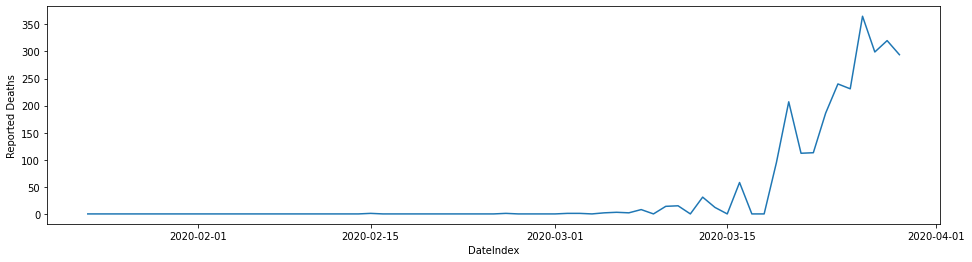

In [22]:
plt.figure(figsize=(16,4))
sns.lineplot(x=simulation_df.index, y="Reported Deaths", data=simulation_df)

In [23]:
record_start = simulation_df["Date"].head(1).values[0]
record_end = simulation_df["Date"].tail(1).values[0]
num_days = (record_end - record_start).days
num_deaths = simulation_df["Deaths"].tail(1).values[0]
print(f"Recorded {num_deaths} COVID-19 deaths from {str(record_start)} to {str(record_end)} ({num_days} days) in the factual data for {country}.")

Recorded 2611.0 COVID-19 deaths from 2020-01-23 to 2020-03-29 (66 days) in the factual data for France.


#### Preprocess the training and validation data

In the training data, actual observed mortality rates for COVID-19 all countries in the dataset is prepared as the dependent variable ($y$), with the countermeasures taken by national governments making up the features ($X$).

In [24]:
def create_train_and_validation_data(df, country, train_split, measures, seq_length):
    train_df = df[df["Country"] != country]
    train_countries = list(filter(lambda c: c != country, df["Country"].unique()))
    
    features = []
    labels = []
    
    # Retrieve the feature sequences and mortality data for each of the countries in the dataset
    for country in train_countries:
        country_df = train_df[train_df["Country"] == country].sort_values(by="Date")
        country_df[["Reported Deaths", "Reported Cases"]] = country_df[["Deaths", "Confirmed Cases"]].diff()
        country_df["Mortality_per_100k"] = country_df["Reported Deaths"] / (
            country_df["2018_Country_Population"].astype(float) / 100000.0)
        country_df["Cases_per_100k"] = country_df["Reported Cases"] / (
            country_df["2018_Country_Population"].astype(float) / 100000.0)
        country_df = country_df.replace([-np.inf, np.inf], np.nan)
        country_df = country_df.fillna(0)
        country_df = country_df.set_index("Date")
        
        country_label_df = country_df["Mortality_per_100k"]
        
        country_label_df.loc[country_label_df < 0.0] = 0.0
        country_features_df = country_df[measures + ["Cases_per_100k"]]
        
        for i in range(int(len(country_df) - seq_length)):
            labels.append(country_label_df[i + seq_length])
            features.append(country_features_df[i: (i + seq_length)].values)
    
    # Shuffle the data
    split_point = int(len(features) * train_split)
    data = list(zip(features, labels))
    random.shuffle(data)
    s_features, s_labels = zip(*data)
    
    # Prepare the data format for the model
    train_X = np.asarray(s_features[0:split_point])
    train_y = np.asarray(s_labels[0:split_point])
    train_y = train_y.reshape((train_y.shape[0], 1))

    val_X = np.asarray(s_features[split_point:len(features)])
    val_y = np.asarray(s_labels[split_point:len(labels)])
    val_y = val_y.reshape((val_y.shape[0], 1))
    
    return train_X, train_y, val_X, val_y

In [25]:
X, y, validation_X, validation_y = create_train_and_validation_data(df, country, train_validation_split, 
                                                                    countermeasures, rnn_params["sequence_length"])

/Users/braadbaart/pysphere/covid/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
print(f"Prepared {len(X)} training and {len(validation_X)} validation samples with feature dimensions {X.shape}.")

Prepared 4551 training and 804 validation samples with feature dimensions (4551, 4, 34).


In [27]:
pd.Series(y.T[0]).describe()

count    4551.000000
mean        0.027121
std         0.390061
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        17.759361
dtype: float64

In [28]:
pd.Series(validation_y.T[0]).describe()

count    804.000000
mean       0.020589
std        0.196090
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.959893
dtype: float64

### Simulation model

In [29]:
model = tf.keras.models.Sequential(name="simulation_model")
model.add(tf.keras.layers.LSTM(rnn_params["cell_units"], bias_initializer='zeros',
          input_shape=(rnn_params["sequence_length"], len(countermeasures) + 1)))
model.add(tf.keras.layers.Dropout(rnn_params["dropout_rate"]))
model.add(tf.keras.layers.Dense(rnn_params["mlp_cells"], activation="relu"))
model.add(tf.keras.layers.Dropout(rnn_params["dropout_rate"]))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [30]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])

In [31]:
model.summary()

Model: "simulation_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                25344     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 26,401
Trainable params: 26,401
Non-trainable params: 0
_________________________________________________________________


In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", mode="min", patience=2)

#### Train the model

In [33]:
train = model.fit(X, y, epochs=rnn_params["num_epochs"], batch_size=rnn_params["batch_size"],
                  callbacks=[early_stopping], validation_data=(validation_X, validation_y))

Train on 4551 samples, validate on 804 samples
Epoch 1/50
4551/4551 [==============================] - 3s 675us/sample - loss: 0.1918 - mse: 0.1918 - mae: 0.1720 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.0274
Epoch 2/50
4551/4551 [==============================] - 1s 190us/sample - loss: 0.1365 - mse: 0.1365 - mae: 0.0364 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.0248
Epoch 3/50
4551/4551 [==============================] - 1s 188us/sample - loss: 0.1330 - mse: 0.1330 - mae: 0.0334 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.0235
Epoch 4/50
4551/4551 [==============================] - 1s 186us/sample - loss: 0.1322 - mse: 0.1322 - mae: 0.0318 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.0210
Epoch 5/50
4551/4551 [==============================] - 1s 188us/sample - loss: 0.1299 - mse: 0.1299 - mae: 0.0294 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.0246
Epoch 6/50
4551/4551 [==============================] - 1s 207us/sample - loss: 0.1276 - mse: 0.1276 - 

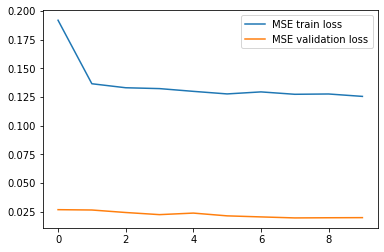

In [34]:
plt.plot(train.history["loss"], label="MSE train loss")
plt.plot(train.history["val_loss"], label="MSE validation loss")
plt.legend()
plt.show()

### Run the country simulation with the learnt RNN parameters

In [35]:
predicted_mortality = model.predict(sim_X)

In [36]:
pd.Series(predicted_mortality.T[0]).describe()

count    6.300000e+01
mean     1.007861e-02
std      3.454357e-02
min      7.124453e-07
25%      2.390329e-06
50%      3.060306e-04
75%      3.074082e-04
max      1.980917e-01
dtype: float64

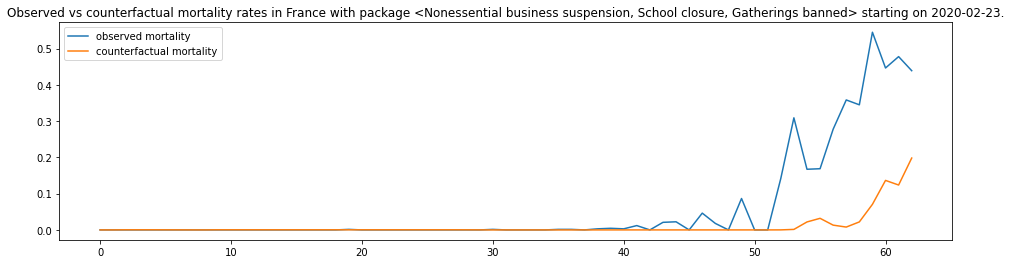

In [37]:
plt.figure(figsize=(16, 4))
plt.plot(sim_y.T[0], label = "observed mortality")
plt.plot(predicted_mortality, label = "counterfactual mortality")
plt.legend()
plt.title(f"Observed vs counterfactual mortality rates in {country} with package <{', '.join(package)}> starting on {cf_start_date}.")
plt.show()